# Projet final Kit Big Data 2022

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pandas as pd
import re
import os
import numpy as np

import time
import datetime
from unidecode import unidecode

from bs4 import BeautifulSoup

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, AwesomeIcon, AntPath, Popup
from ipyleaflet import LayersControl, FullScreenControl, MeasureControl
from ipywidgets import HTML

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
from src.utils import make_request, download_file, create_dir, remove_file, remove_dir
from src.utils import load_csv, save_csv, save_with_xlwings
from src.utils import generate_color_categories

In [4]:
DATA_DIR = 'data/'
DATA_RAW_DIR = DATA_DIR + 'raw/'
DATA_PROCESSED_DIR = DATA_DIR + 'processed/'

# remove_dir(DATA_RAW_DIR)
# remove_dir(DATA_PROCESSED_DIR)

create_dir(DATA_RAW_DIR)
create_dir(DATA_PROCESSED_DIR)

In [5]:
pd.set_option('display.max_columns', None)

# Partie 1 - Acquisition et chargement des données

### A) Acquérir l'ensemble des fichiers Excel des classements via la page de classement

In [6]:
def retrieve_date_rankings_list(url="https://www.vendeeglobe.org/fr/classement", verbose=False):
    """ Retrieve the list of rankings date 
    Args:
        url (String, optional): web page url
    Returns:
        date_rankings_list (List of strings): list of rankings date 
    """
    # Make request
    req = make_request(url, verbose=verbose)

    # Retrieve whole content
    soup = BeautifulSoup(req.content)

    # Retrieve specific information
    soup_info = soup.find('select', class_='form__input m--select onsubmit-rank')

    date_rankings = soup_info.find_all('option')
    date_rankings_list = [date_ranking.get('value') for date_ranking in date_rankings[1:]]
    
    # Remove duplicates
    date_rankings_list = list(set(date_rankings_list))
    return date_rankings_list

In [7]:
date_rankings_list = retrieve_date_rankings_list(verbose=True)
print(f"{len(date_rankings_list)} rankings retrieved")

Request url https://www.vendeeglobe.org/fr/classement
703 rankings retrieved


In [8]:
def download_rankings_results(page_date_rankings, dir_dst='', domain='https://www.vendeeglobe.org', page='/download-race-data/vendeeglobe_{page_id}.xlsx', N=100, verbose=False):
    """ Download rankings results
    Args:
        page_date_rankings (List of strings): list of rankings date 
        dir_dst (String, optional): directory destination path
        domain (String, optional): domain name
        page (String, optional): page name
        N (Integer, optional): number of elements to display if verbose is True
    Returns:
        None
    """
    for page_no, page_date_ranking in enumerate(page_date_rankings):
        
        # Create url and filename dest path
        url = domain + page.format(page_id=page_date_ranking)
        filename = dir_dst + os.path.basename(page.format(page_id=page_date_ranking))

        if verbose:
            if (page_no+1) % N == 0:
                print(f"[{page_no+1}/{len(page_date_rankings)}] downloading pages..")
                
        # Download xlsx file
        download_file(url, filename)
        
    if verbose:
        if len(page_date_rankings) % N:
            print(f"[{page_no+1}/{len(page_date_rankings)}] downloading pages..")

In [9]:
ranking_dir_dst = DATA_RAW_DIR + 'ranking/'

# Create folder if does not exist 
create_dir(ranking_dir_dst)

# Check if directory is empty and download rankings results
if not os.listdir(ranking_dir_dst):
    print(f"Directory '{ranking_dir_dst}' is empty. Downloading rankings results..")
    download_rankings_results(date_rankings_list, dir_dst=ranking_dir_dst, verbose=True)
    print(f"Downloading done.")
else:
    print(f"Data already downloaded into '{ranking_dir_dst}' directory")

Data already downloaded into 'data/raw/ranking/' directory


In [10]:
month_name2month_no = dict(
    janvier=1,
    fevrier=2,
    mars=3,
    avril=4,
    mai=5,
    juin=6,
    juillet=7,
    aout=8,
    septembre=9,
    octobre=10,
    novembre=11,
    decembre=12
)


def get_skipper_race_status(skipper_rank):
    """ Identify skipper race status (whethere skipper is still in race or not)
    Args:
        df (DataFrame): data with multindex in columns
    Returns:
        skipper_in_race (Boolean): skipper race status
    """
    if (isinstance(skipper_rank, str)):
        if skipper_rank.strip().isnumeric():
            skipper_in_race = 'IN RACE'   
        else:
            if 'ARV' in skipper_rank:
                skipper_in_race = 'NOT IN RACE'
            elif 'RET' in skipper_rank:
                skipper_in_race = 'IN RACE'
            else:
                skipper_in_race = np.nan            
    else:
        skipper_in_race = np.nan
    return skipper_in_race



def extract_ranking_datetime(df, verbose=False):
    """ Extract ranking datetime
    Args:
        df (DataFrame): data
    Returns:
        ranking_datetime (Datetime) ranking datetime
    """
    # Retrieve datetime
    ranking_datetime = ' '.join(df.iloc[1][1].split()[3:-1])
    if verbose:
        print(f">>> ranking_datetime: {ranking_datetime}")

    # Divide datetime into elements
    ranking_datetime = re.sub(' à ', ' ', ranking_datetime)
    day, month_name, year, fr_time = tuple(ranking_datetime.split())
    if verbose:
        print(f"day month_name year fr_time: {day} {month_name} {year} {fr_time}")

    # Convert french time to english time (18h00 -> 06:00PM)
    fr_hour, fr_min = tuple(fr_time.split('h'))
    ranking_time = datetime.time(int(fr_hour), int(fr_min))
    if verbose:
        print(f">>> ranking_time: {ranking_time}")

    # Convert string date to date (03 mars 2021 -> 2022-03-01)
    ranking_date = datetime.datetime(int(year), month_name2month_no[unidecode(month_name).lower()], int(day))
    
    if verbose:
        print(f">>> ranking_date: {ranking_date}")

    # Create ranking_datetime using ranking_date and ranking_time
    ranking_datetime = datetime.datetime.combine(ranking_date, ranking_time)
    if verbose:
        print(f">>> ranking_datetime: {ranking_datetime}")
        
    return ranking_datetime



def load_skippers_ranking(ranking_dir_dst, N=100, verbose=False):
    """ Load skippers ranking from xslx files into dataframes
    Args:
        ranking_dir_dst (String, optional): directory destination path
        N (Integer, optional): number of elements to display if verbose is True
    Returns:
        df_skippers_not_in_race (DataFrame): data with skippers whos have finished the race
        df_skippers_in_race (DataFrame): data with skippers still in race/has abandonned the race
    """
    df_skippers_not_in_race = pd.DataFrame()
    df_skippers_in_race = pd.DataFrame()

    ranking_xslx_paths = [ranking_dir_dst+filename for filename in os.listdir(ranking_dir_dst)]#[-50:]
    for file_no, filename in enumerate(ranking_xslx_paths):
        if verbose:
            if (file_no+1) % N == 0:
                print(f"[{file_no+1}/{len(ranking_xslx_paths)}] loading and sorting skippers..")
                
        # Read excel file using xlwings
        uuid_dir_dst = DATA_RAW_DIR + 'uuid/'
        create_dir(uuid_dir_dst)
        filename_uuid = save_with_xlwings(filename, dir_dst=uuid_dir_dst)
        df_skippers = pd.read_excel(filename_uuid) 

        # Insert ranking date
        df_skippers.insert(0, 'ranking_datetime', extract_ranking_datetime(df_skippers))
        
        # Map skippers race status (0: skippers has finished the race, 1: skippers is still/has abandonned in race, NaN: other)
        df_skippers = df_skippers.rename(columns={'Unnamed: 0':'skipper_status'})
        df_skippers['skipper_status'] = df_skippers[list(df_skippers.columns)[2]].apply(lambda x: get_skipper_race_status(x))

        # Add skippers to dfs
        df_skippers_not_in_race = pd.concat([df_skippers_not_in_race, df_skippers[df_skippers['skipper_status'] == 'NOT IN RACE']], ignore_index=True)
        df_skippers_in_race = pd.concat([df_skippers_in_race, df_skippers[df_skippers['skipper_status'] == 'IN RACE']], ignore_index=True)
        
        # Remove uuid file
        remove_file(filename_uuid)
        
    if verbose:
        if len(ranking_xslx_paths) % N:
            print(f"[{file_no+1}/{len(ranking_xslx_paths)}] loading and sorting skippers..")
    
    return df_skippers_not_in_race, df_skippers_in_race

In [11]:
skippers_race_status_raw_dir_dst = DATA_RAW_DIR + 'skippers_race_status/'
filename_not_in_race = skippers_race_status_raw_dir_dst + 'skippers_not_in_race.csv'
filename_in_race = skippers_race_status_raw_dir_dst + 'skippers_in_race.csv'
    
# Create folder if does not exist 
create_dir(skippers_race_status_raw_dir_dst)

# Check if directory is empty and download rankings results
if not os.listdir(skippers_race_status_raw_dir_dst):
    print(f"Directory '{skippers_race_status_raw_dir_dst}' is empty. Loading skippers race status..")
    df_skippers_not_in_race_raw, df_skippers_in_race_raw = load_skippers_ranking(ranking_dir_dst, verbose=True)
    print(f"Loading done.")    
    
    # Save data
    save_csv(df_skippers_not_in_race_raw, csv_path=filename_not_in_race, verbose=True)
    save_csv(df_skippers_in_race_raw, csv_path=filename_in_race, verbose=True)
else:
    df_skippers_not_in_race_raw = load_csv(filename_not_in_race)
    df_skippers_in_race_raw = load_csv(filename_in_race)
    print(f"Data already in '{skippers_race_status_raw_dir_dst}' directory")
    
print(f">>> Total: {df_skippers_not_in_race_raw.shape[0]+df_skippers_in_race_raw.shape[0]} rows skippers:\n\t- {df_skippers_not_in_race_raw.shape[0]} rows: skippers have finished the race\n\t- {df_skippers_in_race_raw.shape[0]} rows: skippers still in race or have abandonned the race")

Data already in 'data/raw/skippers_race_status/' directory
>>> Total: 23161 rows skippers:
	- 3931 rows: skippers have finished the race
	- 19230 rows: skippers still in race or have abandonned the race


In [12]:
df_skippers_not_in_race_raw

,ranking_datetime,skipper_status,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2021-01-27 18:00:00,NOT IN RACE,1\nARV,\nFRA 79,Charlie Dalin\nAPIVIA,NaN,NaN,NaN,27/01/2021 21:35:47 FR,80j 06h 15min 47s\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.6 kts,24355.0 nm,119.6 %,15.1 kts,29135.0 nm
1,2021-01-27 22:00:00,NOT IN RACE,1\nARV,\nFRA 17,Yannick Bestaven\nMaître Coq IV,NaN,NaN,NaN,28/01/2021 05:19:46 FR,80j 03h 44min 46s\n-10h 15min 00s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.6 kts,24365.7 nm,117.3 %,14.8 kts,28583.8 nm
2,2021-01-27 22:00:00,NOT IN RACE,2\nARV,\nFRA 79,Charlie Dalin\nAPIVIA,NaN,NaN,NaN,27/01/2021 21:35:47 FR,80j 06h 15min 47s\n,NaN,NaN,NaN,NaN,02h 31min 01s,NaN,02h 31min 01s,12.6 kts,24365.7 nm,119.6 %,15.1 kts,29135.0 nm
3,2021-01-27 22:00:00,NOT IN RACE,3\nARV,\nFRA 18,Louis Burton\nBureau Vallée 2,NaN,NaN,NaN,28/01/2021 01:45:12 FR,80j 10h 25min 12s\n,NaN,NaN,NaN,NaN,06h 40min 26s,NaN,04h 09min 25s,12.6 kts,24365.7 nm,117.6 %,14.8 kts,28650.0 nm
4,2021-01-28 05:00:00,NOT IN RACE,1\nARV,\nFRA 17,Yannick Bestaven\nMaître Coq IV,NaN,NaN,NaN,28/01/2021 05:19:46 FR,80j 03h 44min 46s\n-10h 15min 00s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.6 kts,24365.7 nm,117.3 %,14.8 kts,28583.8 nm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,2021-03-05 09:00:00,NOT IN RACE,21\nARV,\nFRA 83,Clément Giraud\nCompagnie du lit - Jiliti,NaN,NaN,NaN,16/02/2021 10:28:31 FR,99j 20h 08min 31s\n,NaN,NaN,NaN,NaN,19j 16h 23min 45s,NaN,2j 13h 41min 28s,10.2 kts,24365.7 nm,115.5 %,11.7 kts,28137.8 nm
3927,2021-03-05 09:00:00,NOT IN RACE,22\nARV,\nFRA 50,Miranda Merron\nCampagne de France,NaN,NaN,NaN,17/02/2021 23:16:51 FR,101j 08h 56min 51s\n,NaN,NaN,NaN,NaN,21j 05h 12min 05s,NaN,1j 12h 48min 20s,10.0 kts,24365.7 nm,113.5 %,11.4 kts,27656.2 nm
3928,2021-03-05 09:00:00,NOT IN RACE,23\nARV,\nFRA 71,Manuel Cousin\nGroupe Sétin,NaN,NaN,NaN,20/02/2021 08:35:40 FR,103j 18h 15min 40s\n,NaN,NaN,NaN,NaN,23j 14h 30min 54s,NaN,2j 09h 18min 49s,9.8 kts,24365.7 nm,119.5 %,11.7 kts,29115.7 nm
3929,2021-03-05 09:00:00,NOT IN RACE,24\nARV,\nFRA 72,Alexia Barrier\nTSE - 4myplanet,NaN,NaN,NaN,28/02/2021 07:23:44 FR,111j 17h 03min 44s\n,NaN,NaN,NaN,NaN,31j 13h 18min 58s,NaN,7j 22h 48min 04s,9.1 kts,24365.7 nm,115.6 %,10.5 kts,28170.7 nm


In [13]:
df_skippers_in_race_raw

,ranking_datetime,skipper_status,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2020-11-08 16:00:00,IN RACE,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,357°,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm
1,2020-11-08 16:00:00,IN RACE,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,357°,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm
2,2020-11-08 16:00:00,IN RACE,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,357°,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm
3,2020-11-08 16:00:00,IN RACE,4,\nFRA 59,Thomas Ruyant\nLinkedOut,15:30 FR\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,357°,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm
4,2020-11-08 16:00:00,IN RACE,5,\nFRA 53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,357°,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19225,2021-03-05 09:00:00,IN RACE,RET,\nFRA 109,Samantha Davies\nInitiatives - Coeur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19226,2021-03-05 09:00:00,IN RACE,RET,\nFRA 4,Sébastien Simon\nARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19227,2021-03-05 09:00:00,IN RACE,RET,\nGBR 99,Alex Thomson\nHUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19228,2021-03-05 09:00:00,IN RACE,RET,\nFRA 85,Kevin Escoffier\nPRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### B) Acquérir les caractéristiques des bateaux

In [14]:
def retrieve_boats_characteristics(url="https://www.vendeeglobe.org/fr/glossaire", verbose=False):
    """ Retrieve the list of rankings date 
    Args:
        url (String, optional): web page url
    Returns:
        df_boats_characteristics (DataFrame): boats characteristics
    """
    boats_characteristics_list = []

    # Make request
    req = make_request(url, verbose=verbose)

    # Retrieve whole content
    soup = BeautifulSoup(req.content)

    # Retrieve specific information
    current_boats_info = soup.find_all('div', class_='boats-list__infos')
    boats_name = [current_boat_info.find('h3').text.strip() for current_boat_info in current_boats_info]
    skippers_name = [current_boat_info.find('span').text.strip() for current_boat_info in current_boats_info]
    
    soup_info = soup.find_all('div', class_='boats-list__popup-infos')
    for boat_no, soup_boat_info in enumerate(soup_info):
        boat_info = soup_boat_info.find_all('li')

        # Retrieve the boat characteristics
        boat_characteristics = [tuple(characteristics.text.split(' : ', maxsplit=1)) for characteristics in boat_info]
        boat_characteristics = dict(map(reversed, boat_characteristics))
        boat_characteristics = {v: k for k, v in boat_characteristics.items()}
        dct = dict(skipper_name=skippers_name[boat_no], boat_name=boats_name[boat_no])
        dct.update(boat_characteristics)
        boats_characteristics_list.append(dct)

    df_boats_characteristics = pd.DataFrame(boats_characteristics_list)
    return df_boats_characteristics

In [15]:
boat_raw_dir_dst = DATA_RAW_DIR + 'boat/'
filename = boat_raw_dir_dst + 'boats_characteristics.csv'

# Create folder if does not exist 
create_dir(boat_raw_dir_dst)

# Check if directory is empty and retrieve boats characteristics
if not os.listdir(boat_raw_dir_dst):
    print(f"Directory '{boat_raw_dir_dst}' is empty. Scraping boats characteristics..")
    df_boats_characteristics_raw = retrieve_boats_characteristics(verbose=True)
    print(f"Scraping done.\n")
    
    # Save data
    save_csv(df_boats_characteristics_raw, csv_path=filename, verbose=True)
    
else:
    df_boats_characteristics_raw = load_csv(filename)
    
df_boats_characteristics_raw

,skipper_name,boat_name,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice AMEDEO,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,Romain ATTANASIO,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,Alexia BARRIER,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Yannick BESTAVEN,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,Jérémie BEYOU,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
5,Arnaud BOISSIÈRES,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
6,Louis BURTON,BUREAU VALLEE 2,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
7,Didac COSTA,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,02 Février 2000,"18,28 m","5,30 m","4,50 m","8,9 t",2,26 m,acier,240 m2,470 m2
8,Manuel COUSIN,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,"18,28 m","5,80 m","4,50 m",9 t,2 asymétriques,"28,50",basculante sur vérin hydraulique,270 m2,560 m2
9,Clarisse CREMER,BANQUE POPULAIRE X,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,"18,28 m","5,70 m","4,5 m","7,7 t",2,29 m,acier forgé,340 m2,570 m2


# Partie 2 - Préparation des données

### A) Préparation des données relatives aux classements.

In [16]:
def get_skipper_cols(skipper_in_race):
    """ Get skipper columns in function of his race status
    Args:
        skipper_in_race (Boolean): skipper race status
    Returns:
        cols (List of strings): columns related to skipper race status
    """
    skipper_class2cols = {
        0: [
            'ranking_datetime', 'skipper_status', 
            'rank', 'nationality & sail', 'skipper & crew',
            'arrival_date', 'race_time', 
            'gaps_to_first', 'gaps_to_previous', 
            'over_ortho_speed', 'over_ortho_distance', 'play',
            'over_ground_speed', 'over_ground_distance' 
        ],
        1: [
            'ranking_datetime', 'skipper_status', 
            'rank', 'nationality & sail', 'skipper & crew', 'hour_fr', 'latitude', 'longitude',
            'since30min_heading', 'since30min_speed', 'since30min_vmg', 'since30min_distance', 
            'sincelastreport_heading', 'sincelastreport_speed', 'sincelastreport_vmg', 'sincelastreport_distance',
            'since24hours_heading', 'since24hours_speed', 'since24hours_vmg', 'since24hours_distance',
            'dtf', 'dtl'
        ]
    }
    cols = skipper_class2cols[int(skipper_in_race)]
    return cols


def dms2dec(deg, mn, sec):
    """ Convert degree, minutes and secondes into decimal number 
    Args:
    Returns:
    """
    dec = deg + mn/60 + sec/3600
    return dec


def process_coordinate(coordinate, pole_sign=dict(N=1, S=-1, E=1, W=-1), verbose=False):
    """ Process latitude or longitude coordinate
    Args:
    Returns:
    """
    coord_split = coordinate.split('°')
    deg = float(coord_split[0])
    
    coord_split = coord_split[-1].split("'")
    mn = float(coord_split[0])
    pole = coord_split[-1]
    
    if verbose:
        print(f"deg: {deg}, mn: {mn}, pole: {pole}")

    coord_dec = dms2dec(deg=deg, mn=mn, sec=0)    
    coord_dec = coord_dec*pole_sign[pole]
    if verbose:
        print('coord_dec', coord_dec)
    return coord_dec



def preprocess_skippers_ranking(df_skippers_not_in_race, df_skippers_in_race, verbose=False):
    """ Load skippers ranking from xslx files into dataframes
    Args:
        df_skippers_not_in_race (DataFrame): data with skippers whos have finished the race
        df_skippers_in_race (DataFrame): data with skippers still in race/has abandonned the race
    Returns:
        df_not_in (DataFrame): preprocessed dataframe
        df_in (DataFrame): preprocessed dataframe
    """
    df_not_in = df_skippers_not_in_race.copy()
    df_in = df_skippers_in_race.copy()
    
    # Drop columns with only NaN values
    df_not_in = df_not_in.dropna(axis=1, how='all')
    df_in = df_in.dropna(axis=1, how='all')

    # Rename columns
    df_not_in.columns = get_skipper_cols(skipper_in_race=False)
    df_in.columns = get_skipper_cols(skipper_in_race=True)
    
    # Clean data (df_not_in)
    df_not_in['rank'] = df_not_in['rank'].apply(lambda x: x.split()[0])
    
    df_not_in['nationality'] = df_not_in['nationality & sail'].apply(lambda x: x.split()[0])
    df_not_in['sail'] = df_not_in['nationality & sail'].apply(lambda x: x.split()[1])
    
    df_not_in['skipper_firstname'] = df_not_in['skipper & crew'].apply(lambda x: x.split('\n')[0].split()[0])
    df_not_in['skipper_lastname'] = df_not_in['skipper & crew'].apply(lambda x: ' '.join(x.split('\n')[0].split()[1:]).upper().replace(' ', ''))
    df_not_in['crew_name'] = df_not_in['skipper & crew'].apply(lambda x: x.split('\n')[1])
    
    df_not_in['race_time_gap'] = df_not_in['race_time'].apply(lambda x: x.split('\n')[-1])
    df_not_in['race_time'] = df_not_in['race_time'].apply(lambda x: x.split('\n')[0])
    df_not_in['arrival_date'] = df_not_in['arrival_date'].apply(lambda x: datetime.datetime.strptime(x.replace(' FR', ''), '%d/%m/%Y %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S'))
    
    df_not_in['over_ortho_speed'] = df_not_in['over_ortho_speed'].apply(lambda x: float(x.replace(' kts', '')))
    df_not_in['over_ortho_distance'] = df_not_in['over_ortho_distance'].apply(lambda x: float(x.replace(' nm', '')))
    df_not_in['over_ground_speed'] = df_not_in['over_ground_speed'].apply(lambda x: float(x.replace(' kts', '')))
    df_not_in['over_ground_distance'] = df_not_in['over_ground_distance'].apply(lambda x: float(x.replace(' nm', '')))
    df_not_in['play'] = df_not_in['play'].apply(lambda x: float(x.replace(' %', '')))
    
    # Clean data (df_in)
    df_in['rank'] = df_in['rank'].apply(lambda x: -1 if x == 'RET' else x)
    
    df_in['nationality'] = df_in['nationality & sail'].apply(lambda x: x.split()[0])
    df_in['sail'] = df_in['nationality & sail'].apply(lambda x: x.split()[1])
    
    df_in['skipper_firstname'] = df_in['skipper & crew'].apply(lambda x: x.split('\n')[0].split()[0])
    df_in['skipper_lastname'] = df_in['skipper & crew'].apply(lambda x: ' '.join(x.split('\n')[0].split()[1:]).upper().replace(' ', ''))
    df_in['crew_name'] = df_in['skipper & crew'].apply(lambda x: x.split('\n')[1])
    
    df_in['hour_fr'] = df_in['hour_fr'].apply(lambda x: datetime.datetime.strptime(x.split(' FR')[0], '%H:%M').strftime('%H:%M:%S') if isinstance(x, str) else np.nan)
    df_in['latitude'] = df_in['latitude'].apply(lambda x: process_coordinate(x) if isinstance(x, str) else np.nan)
    df_in['longitude'] = df_in['longitude'].apply(lambda x: process_coordinate(x) if isinstance(x, str) else np.nan)
    
    df_in['since30min_heading'] = df_in['since30min_heading'].apply(lambda x: float(x.replace('°', '')) if isinstance(x, str) else np.nan)
    df_in['sincelastreport_heading'] = df_in['sincelastreport_heading'].apply(lambda x: float(x.replace('°', '')) if isinstance(x, str) else np.nan)
    df_in['since24hours_heading'] = df_in['since24hours_heading'].apply(lambda x: float(x.replace('°', '')) if isinstance(x, str) else np.nan)
    
    df_in['since30min_speed'] = df_in['since30min_speed'].apply(lambda x: float(x.replace(' kts', '')) if isinstance(x, str) else np.nan)
    df_in['sincelastreport_speed'] = df_in['sincelastreport_speed'].apply(lambda x: float(x.replace(' kts', '')) if isinstance(x, str) else np.nan)
    df_in['since24hours_speed'] = df_in['since24hours_speed'].apply(lambda x: float(x.replace(' kts', '')) if isinstance(x, str) else np.nan)
    
    df_in['since30min_vmg'] = df_in['since30min_vmg'].apply(lambda x: float(x.replace(' kts', '')) if isinstance(x, str) else np.nan)
    df_in['sincelastreport_vmg'] = df_in['sincelastreport_vmg'].apply(lambda x: float(x.replace(' kts', '')) if isinstance(x, str) else np.nan)
    df_in['since24hours_vmg'] = df_in['since24hours_vmg'].apply(lambda x: float(x.replace(' kts', '')) if isinstance(x, str) else np.nan)
    
    df_in['since30min_distance'] = df_in['since30min_distance'].apply(lambda x: float(x.replace(' nm', '')) if isinstance(x, str) else np.nan)
    df_in['sincelastreport_distance'] = df_in['sincelastreport_distance'].apply(lambda x: float(x.replace(' nm', '')) if isinstance(x, str) else np.nan)
    df_in['since24hours_distance'] = df_in['since24hours_distance'].apply(lambda x: float(x.replace(' nm', '')) if isinstance(x, str) else np.nan)
    
    df_in['dtf'] = df_in['dtf'].apply(lambda x: float(x.replace(' nm', '')) if isinstance(x, str) else np.nan)
    df_in['dtl'] = df_in['dtl'].apply(lambda x: float(x.replace(' nm', '')) if isinstance(x, str) else np.nan)
    
    
    # Drop useless columns
    df_not_in = df_not_in.drop(columns=['nationality & sail', 'skipper & crew'])
    df_in = df_in.drop(columns=['nationality & sail', 'skipper & crew'])
    
    # Set ordered columns
    ordered_cols_not_in = ['ranking_datetime', 'skipper_status', 'rank', 'sail', 'nationality', 'skipper_lastname', 'skipper_firstname', 'crew_name', 'race_time', 'race_time_gap']
    df_not_in = df_not_in.reindex(columns=(ordered_cols_not_in + list([col for col in df_not_in.columns if col not in ordered_cols_not_in])))
    
    ordered_cols_in = ['ranking_datetime', 'skipper_status', 'rank', 'sail', 'nationality', 'skipper_lastname', 'skipper_firstname', 'crew_name']
    df_in = df_in.reindex(columns=(ordered_cols_in + list([col for col in df_in.columns if col not in ordered_cols_in])))
    
    # Replace '' by NaN
    df_not_in = df_not_in.replace('', np.nan)
    df_in = df_in.replace('', np.nan)
    
    return df_not_in, df_in

In [17]:
skippers_race_status_processed_dir_dst = DATA_PROCESSED_DIR + 'skippers_race_status/'

filename_not_in_race = skippers_race_status_processed_dir_dst + 'skippers_not_in_race.csv'
filename_in_race = skippers_race_status_processed_dir_dst + 'skippers_in_race.csv'

# Create folder if does not exist 
create_dir(skippers_race_status_processed_dir_dst)

# Check if directory is empty and retrieve boats characteristics
if not os.listdir(skippers_race_status_processed_dir_dst):
    print(f"Directory '{skippers_race_status_processed_dir_dst}' is empty. Cleaning skippers ranking..")

    # Preprocess data
    df_skippers_not_in_race, df_skippers_in_race = preprocess_skippers_ranking(df_skippers_not_in_race_raw, df_skippers_in_race_raw, verbose=True)
    print(f"Cleaning done.\n")
    
    # Save data
    save_csv(df_skippers_not_in_race, csv_path=filename_not_in_race, verbose=True)
    save_csv(df_skippers_in_race, csv_path=filename_in_race, verbose=True)
else:
    df_skippers_in_race = load_csv(filename_in_race)
    df_skippers_not_in_race = load_csv(filename_not_in_race)
    print(f"Preprocessed data loaded.")

Preprocessed data loaded.


In [18]:
df_skippers_not_in_race

,ranking_datetime,skipper_status,rank,sail,nationality,skipper_lastname,skipper_firstname,crew_name,race_time,race_time_gap,arrival_date,gaps_to_first,gaps_to_previous,over_ortho_speed,over_ortho_distance,play,over_ground_speed,over_ground_distance
0,2021-01-27 18:00:00,NOT IN RACE,1,79,FRA,DALIN,Charlie,APIVIA,80j 06h 15min 47s,NaN,2021-01-27 21:35:47,NaN,NaN,12.6,24355.0,119.6,15.1,29135.0
1,2021-01-27 22:00:00,NOT IN RACE,1,17,FRA,BESTAVEN,Yannick,Maître Coq IV,80j 03h 44min 46s,-10h 15min 00s,2021-01-28 05:19:46,NaN,NaN,12.6,24365.7,117.3,14.8,28583.8
2,2021-01-27 22:00:00,NOT IN RACE,2,79,FRA,DALIN,Charlie,APIVIA,80j 06h 15min 47s,NaN,2021-01-27 21:35:47,02h 31min 01s,02h 31min 01s,12.6,24365.7,119.6,15.1,29135.0
3,2021-01-27 22:00:00,NOT IN RACE,3,18,FRA,BURTON,Louis,Bureau Vallée 2,80j 10h 25min 12s,NaN,2021-01-28 01:45:12,06h 40min 26s,04h 09min 25s,12.6,24365.7,117.6,14.8,28650.0
4,2021-01-28 05:00:00,NOT IN RACE,1,17,FRA,BESTAVEN,Yannick,Maître Coq IV,80j 03h 44min 46s,-10h 15min 00s,2021-01-28 05:19:46,NaN,NaN,12.6,24365.7,117.3,14.8,28583.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,2021-03-05 09:00:00,NOT IN RACE,21,83,FRA,GIRAUD,Clément,Compagnie du lit - Jiliti,99j 20h 08min 31s,NaN,2021-02-16 10:28:31,19j 16h 23min 45s,2j 13h 41min 28s,10.2,24365.7,115.5,11.7,28137.8
3927,2021-03-05 09:00:00,NOT IN RACE,22,50,FRA,MERRON,Miranda,Campagne de France,101j 08h 56min 51s,NaN,2021-02-17 23:16:51,21j 05h 12min 05s,1j 12h 48min 20s,10.0,24365.7,113.5,11.4,27656.2
3928,2021-03-05 09:00:00,NOT IN RACE,23,71,FRA,COUSIN,Manuel,Groupe Sétin,103j 18h 15min 40s,NaN,2021-02-20 08:35:40,23j 14h 30min 54s,2j 09h 18min 49s,9.8,24365.7,119.5,11.7,29115.7
3929,2021-03-05 09:00:00,NOT IN RACE,24,72,FRA,BARRIER,Alexia,TSE - 4myplanet,111j 17h 03min 44s,NaN,2021-02-28 07:23:44,31j 13h 18min 58s,7j 22h 48min 04s,9.1,24365.7,115.6,10.5,28170.7


In [19]:
df_skippers_in_race

,ranking_datetime,skipper_status,rank,sail,nationality,skipper_lastname,skipper_firstname,crew_name,hour_fr,latitude,longitude,since30min_heading,since30min_speed,since30min_vmg,since30min_distance,sincelastreport_heading,sincelastreport_speed,sincelastreport_vmg,sincelastreport_distance,since24hours_heading,since24hours_speed,since24hours_vmg,since24hours_distance,dtf,dtl
0,2020-11-08 16:00:00,IN RACE,1,18,FRA,BURTON,Louis,Bureau Vallée 2,15:30:00,46.407667,-1.841333,241.0,17.7,17.5,0.3,357.0,0.0,0.0,2788.0,201.0,0.3,0.3,6.1,24293.9,0.0
1,2020-11-08 16:00:00,IN RACE,2,10,MON,HERRMANN,Boris,Seaexplorer - Yacht Club De Monaco,15:31:00,46.405667,-1.830333,241.0,11.1,10.9,0.4,357.0,0.0,0.0,2787.9,196.0,0.3,0.2,6.0,24294.2,0.4
2,2020-11-08 16:00:00,IN RACE,3,8,FRA,BEYOU,Jérémie,Charal,15:30:00,46.415167,-1.833167,244.0,15.5,15.5,0.5,357.0,0.0,0.0,2788.5,199.0,0.2,0.2,5.5,24294.3,0.5
3,2020-11-08 16:00:00,IN RACE,4,59,FRA,RUYANT,Thomas,LinkedOut,15:30:00,46.411833,-1.828000,244.0,13.2,13.1,0.7,357.0,0.0,0.0,2788.3,196.0,0.2,0.2,5.6,24294.5,0.6
4,2020-11-08 16:00:00,IN RACE,5,53,FRA,SOREL,Maxime,V And B Mayenne,15:30:00,46.409833,-1.826000,246.0,10.9,10.9,0.2,357.0,0.0,0.0,2788.1,195.0,0.8,0.7,5.8,24294.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19225,2021-03-05 09:00:00,IN RACE,-1,109,FRA,DAVIES,Samantha,Initiatives - Coeur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19226,2021-03-05 09:00:00,IN RACE,-1,4,FRA,SIMON,Sébastien,ARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19227,2021-03-05 09:00:00,IN RACE,-1,99,GBR,THOMSON,Alex,HUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19228,2021-03-05 09:00:00,IN RACE,-1,85,FRA,ESCOFFIER,Kevin,PRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### B) Extraction des caractéristiques techniques de chacun des voiliers.

In [20]:
def convert_fr_date2en_date(fr_date):
    """ Convert french date into english date
    Args:
    Returns:
    """
    day, month, year = tuple(fr_date.split())
    month = month_name2month_no[unidecode(month).lower()]
    return datetime.datetime(int(year), int(month), int(day))


def preprocess_boats_characteristics(df_boats_characteristics, verbose=False):
    """ Load skippers ranking from xslx files into dataframes
    Args:
        df_boats_characteristics (DataFrame): data with skippers whos have finished the race
    Returns:
        df (DataFrame): preprocessed dataframe
    """
    df = df_boats_characteristics.copy()

    # Rename columns
    df = df.rename(columns={
        'skipper_name': 'skipper_name',
        'boat_name': 'crew_name',
        'Numéro de voile': 'nationality & sail',
        'Anciens noms du bateau': 'former_crew_names',
        'Architecte': 'architect',
        'Chantier': 'place_of_work',
        'Date de lancement': 'launch_date',
        'Longueur': 'length',
        'Largeur': 'width',
        "Tirant d'eau": 'water_draft',
        'Déplacement (poids)': 'weigth',
        'Nombre de dérives': 'drift_amount',  
        'Hauteur mât': 'mast_height',  
        'Voile quille': 'keel_sail',  
        'Surface de voiles au près': 'upwind_sail_area',  
        'Surface de voiles au portant': 'downwind_sail_area',    
    })

    # Skipper meta-data
    df['skipper_firstname'] = df['skipper_name'].apply(lambda x: ''.join([word for word in x.split() if not word.isupper()]))
    df['skipper_lastname'] = df['skipper_name'].apply(lambda x: unidecode(''.join([word for word in x.split() if word.isupper()])))
    df['nationality & sail'] = df['nationality & sail'].apply(lambda x: ' '.join([x[:3], x[3:]]) if (isinstance(x, str) and (len(x) > 3)) else x)
    df['nationality'] = df['nationality & sail'].apply(lambda x: ''.join([l for l in x if (l.lower().isalpha())]) if isinstance(x, str) else np.nan)
    df['sail'] = df['nationality & sail'].apply(lambda x: ''.join([l for l in x if l.isdigit()]) if isinstance(x, str) else np.nan)
    df = df.drop(columns=['skipper_name', 'nationality & sail'])
    df = df.reindex(columns=(['skipper_firstname', 'skipper_lastname', 'nationality', 'sail'] + list([col for col in df.columns if col not in ['skipper_firstname', 'skipper_lastname', 'nationality', 'sail']])))

    # Convert launch_date into datetime format
    df['launch_date'] = df['launch_date'].apply(lambda x: convert_fr_date2en_date(x))

    # Clean length, width, water_draft, weigth, mast_height, upwind_sail_area, downwind_sail_area
    df['length'] = df['length'].apply(lambda x: float(re.sub(r"([^0-9,]+)",'', x).replace(',', '.')) if (isinstance(x, str) and any([l.isdigit() for l in x])) else np.nan)
    df['width'] = df['width'].apply(lambda x: float(re.sub(r"([^0-9,]+)",'', x).replace(',', '.')) if (isinstance(x, str) and any([l.isdigit() for l in x])) else np.nan)
    df['water_draft'] = df['water_draft'].apply(lambda x: float(re.sub(r"([^0-9,]+)",'', x).replace(',', '.')) if (isinstance(x, str) and any([l.isdigit() for l in x])) else np.nan)
    df['weigth'] = df['weigth'].apply(lambda x: float(re.sub(r"([^0-9,]+)",'', x).replace(',', '.')) if (isinstance(x, str) and any([l.isdigit() for l in x])) else np.nan)
    df['mast_height'] = df['mast_height'].apply(lambda x: float(re.sub(r"([^0-9,]+)",'', x).replace(',', '.')) if (isinstance(x, str) and any([l.isdigit() for l in x])) else np.nan)
    df['upwind_sail_area'] = df['upwind_sail_area'].apply(lambda x: float(x[:3]) if (isinstance(x, str) and len(x)>3) else np.nan)
    df['downwind_sail_area'] = df['downwind_sail_area'].apply(lambda x: float(x[:3]) if (isinstance(x, str) and len(x)>3) else np.nan)

    # Map drift_amount
    # drift_amount2no = {drift_amount:no for no, drift_amount in enumerate(df['drift_amount'].dropna().unique().tolist())}
    # no2drift_amounts = {v:k for k,v in drift_amount2no.items()}
    # df['drift_amount'] = df['drift_amount'].apply(lambda x: drift_amount2no[x] if isinstance(x, str) else np.nan)
    df['drift_amount'] = df['drift_amount'].apply(lambda x: '>2' if x in ['foils', 'foiler'] else x if isinstance(x, str) else np.nan)


    # Map keel_sail
    keel2no = {keel:no for no, keel in enumerate(df['keel_sail'].dropna().unique().tolist())}
    no2keels = {v:k for k,v in keel2no.items()}
    df['keel_sail'] = df['keel_sail'].apply(lambda x: keel2no[x] if isinstance(x, str) else np.nan)
    
    # Handle outlier
    outlier_skipper_name = 'FrançoisGuiffant'
    outlier_skipper_name_idx = df[df['skipper_firstname']==outlier_skipper_name].index[0]
    df.at[outlier_skipper_name_idx, 'skipper_firstname'] = 'François'
    df.at[outlier_skipper_name_idx, 'skipper_lastname'] = 'Guiffant'.upper()
    
    # Replace '' by NaN
    df = df.replace('', np.nan)
    
    # Add skipper id
    df.insert(0, 'skipper_id', df.groupby(['skipper_lastname','skipper_firstname']).ngroup())

    return df

In [21]:
boat_processed_dir_dst = DATA_PROCESSED_DIR + 'boat/'

filename_raw = boat_raw_dir_dst + 'boats_characteristics.csv'
filename_processed = boat_processed_dir_dst + 'boats_characteristics.csv'

# Create folder if does not exist 
create_dir(boat_processed_dir_dst)

# Check if directory is empty and retrieve boats characteristics
if not os.listdir(boat_processed_dir_dst):
    print(f"Directory '{boat_processed_dir_dst}' is empty. Cleaning boats characteristics..")
    
    # Preprocess data
    df_boats_characteristics = preprocess_boats_characteristics(df_boats_characteristics_raw, verbose=True)
    print(f"Cleaning done.\n")
    
    # Save data
    save_csv(df_boats_characteristics, csv_path=filename_processed, verbose=True)
else:    
    df_boats_characteristics = load_csv(filename_processed)
    
df_boats_characteristics

,skipper_id,skipper_firstname,skipper_lastname,nationality,sail,crew_name,former_crew_names,architect,place_of_work,launch_date,length,width,water_draft,weigth,drift_amount,mast_height,keel_sail,upwind_sail_area,downwind_sail_area
0,0,Fabrice,AMEDEO,FRA,56.0,NEWREST - ART & FENÊTRES,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-08-01,18.28,5.85,4.5,7.0,>2,29.0,0.0,320.0,570.0
1,1,Romain,ATTANASIO,FRA,49.0,PURE - Best Western®,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-03-08,18.28,5.80,4.5,9.0,2,28.0,1.0,280.0,560.0
2,2,Alexia,BARRIER,FRA,72.0,TSE - 4MYPLANET,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,18.28,5.54,4.5,9.0,2,29.0,2.0,260.0,580.0
3,3,Yannick,BESTAVEN,NaN,17.0,Maître CoQ IV,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015-03-12,18.28,5.80,4.5,8.0,>2,29.0,3.0,310.0,550.0
4,4,Jérémie,BEYOU,NaN,8.0,CHARAL,NaN,VPLP,CDK Technologies,2018-08-18,18.28,5.85,4.5,8.0,>2,29.0,2.0,320.0,600.0
5,5,Arnaud,BOISSIERES,FRA,14.0,LA MIE CÂLINE - ARTISANS ARTIPÔLE,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,2007-08-03,18.28,5.65,4.5,7.9,>2,29.0,4.0,300.0,610.0
6,6,Louis,BURTON,NaN,18.0,BUREAU VALLEE 2,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,2015-06-09,18.28,5.80,4.5,7.6,>2,28.0,2.0,300.0,600.0
7,7,Didac,COSTA,ESP,33.0,ONE PLANET ONE OCEAN,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,2000-02-02,18.28,5.30,4.5,8.9,2,26.0,2.0,240.0,470.0
8,8,Manuel,COUSIN,FRA,71.0,GROUPE SÉTIN,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),2007-02-02,18.28,5.80,4.5,9.0,2 asymétriques,28.5,5.0,270.0,560.0
9,9,Clarisse,CREMER,FRA,30.0,BANQUE POPULAIRE X,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,2011-03-01,18.28,5.70,4.5,7.7,2,29.0,1.0,340.0,570.0


##### L'ajout d'un ID pour les skippers permet de manipuler plus facilement les données et surtout de pouvoir fait une jointure entre les données de courses et les caractéristiques des voiliers

### C) NaN values analysis

In [22]:
def plot_NaN_values(df_plot, title, fig, plot_no, data_type):
    """ Visualize NaN values """
    df_nan_values = df_plot.isna().sum().to_frame(name='count')
    df_nan_values['percentage'] = round(df_nan_values['count']/df_plot.shape[0]*100)
    df_nan_values['percentage_name'] = df_nan_values['percentage'].astype(str) + "%"
    df_nan_values['data_type'] = df_nan_values.index
    df_nan_values = df_nan_values.reset_index(drop=True)
    df_nan_values = df_nan_values.sort_values(by=['percentage'])

    fig.add_trace(go.Bar(
        name=title,
        x=df_nan_values['count'],
        y=df_nan_values['data_type'],
        text=df_nan_values['percentage_name'],
        customdata=df_nan_values['percentage_name'],
        hovertemplate="<b>%{y}</b><br>Count: %{x}/"+str(df_plot.shape[0])+"<br>Percentage: %{customdata}",
        orientation='h'
    ),
    row=plot_no[0] , col=plot_no[1]
    )
    fig.update_traces(textfont_size=20, textangle=0, textposition="outside", cliponaxis=False)
    fig.update_layout(
        height=1500,# width=1200,
        title={"text": f"<b>NaN values distribution ({data_type} data)</b>", "x": 0.5},
    )
    return fig



def subplot_NaN_values(df_skippers_not_in_race, df_skippers_in_race, df_boats_characteristics, subtitles, data_type='raw'):
    """ Subplot NaN values """
    N_rows, N_cols = 3, 1
    fig = make_subplots(
        rows=N_rows, cols=N_cols,
        subplot_titles=subtitles,
        vertical_spacing = 0.1
    )

    fig = plot_NaN_values(df_skippers_not_in_race, title=subtitles[0], fig=fig, plot_no=(1, 1), data_type=data_type)
    fig = plot_NaN_values(df_skippers_in_race, title=subtitles[1], fig=fig , plot_no=(2, 1), data_type=data_type)
    fig = plot_NaN_values(df_boats_characteristics, title=subtitles[2], fig=fig , plot_no=(3, 1), data_type=data_type)

    # Update xaxis properties
    fig.update_xaxes(title_text="NaN values count", range=[0, df_skippers_not_in_race.shape[0]], row=1, col=1)
    fig.update_xaxes(title_text="NaN values count", range=[0, df_skippers_in_race.shape[0]], row=2, col=1)
    fig.update_xaxes(title_text="NaN values count", range=[0, df_boats_characteristics.shape[0]], row=3, col=1)

    # Update xaxis properties
    fig.update_yaxes(title_text="Column name", row=1, col=1)
    fig.update_yaxes(title_text="Column name", row=2, col=1)
    fig.update_yaxes(title_text="Column name", row=3, col=1)

    fig.show()

##### Une première analyse consiste à visualiser les données manquantes dans chaque dataframe

In [23]:
subtitles = ['Skippers have finished the race', 'Skippers still in race/have abandonned', 'Boats characteristics']
subplot_NaN_values(df_skippers_not_in_race, df_skippers_in_race, df_boats_characteristics, subtitles=subtitles, data_type='preprocessed')

### D) Rapprochement des données des voiliers avec celles des classements.

##### Afin d'assoocier les données sur les caractéristiques des voiliers à chaque skipper, il est nécessaire de créer/utiliser l'ID des skippers dans chaque table.

In [24]:
skipper_lastname2skipper_id = dict(map(reversed, df_boats_characteristics[['skipper_id', 'skipper_lastname']].drop_duplicates().values))
print(skipper_lastname2skipper_id)

{'AMEDEO': 0, 'ATTANASIO': 1, 'BARRIER': 2, 'BESTAVEN': 3, 'BEYOU': 4, 'BOISSIERES': 5, 'BURTON': 6, 'COSTA': 7, 'COUSIN': 8, 'CREMER': 9, 'DALIN': 10, 'DAVIES': 11, 'DESTREMAU': 12, 'DUTREUX': 13, 'ESCOFFIER': 14, 'GIRAUD': 15, 'GUIFFANT': 16, 'HARE': 17, 'HERRMANN': 18, 'HUUSELA': 19, 'JOSCHKE': 20, 'LECAM': 21, 'LEDIRAISON': 22, 'MERRON': 23, 'PEDOTE': 24, 'ROURA': 25, 'RUYANT': 26, 'SEGUIN': 27, 'SHIRAISHI': 28, 'SIMON': 29, 'SOREL': 30, 'THOMSON': 31, 'TRIPON': 32, 'TROUSSEL': 33}


In [25]:
unique_skippers_boats = list(sorted(skipper_lastname2skipper_id.keys()))
print(f"unique_skippers_boats ({len(unique_skippers_boats)}):\n{unique_skippers_boats}\n")

unique_skippers_not_in = list(sorted(df_skippers_not_in_race['skipper_lastname'].unique().tolist()))
print(f"unique_skippers_not_in_race ({len(unique_skippers_not_in)}):\n{unique_skippers_not_in}\n")

unique_skippers_in = list(sorted(df_skippers_in_race['skipper_lastname'].unique().tolist()))
print(f"unique_skippers_in_race ({len(unique_skippers_in)}):\n{unique_skippers_in}")

unique_skippers_boats (34):
['AMEDEO', 'ATTANASIO', 'BARRIER', 'BESTAVEN', 'BEYOU', 'BOISSIERES', 'BURTON', 'COSTA', 'COUSIN', 'CREMER', 'DALIN', 'DAVIES', 'DESTREMAU', 'DUTREUX', 'ESCOFFIER', 'GIRAUD', 'GUIFFANT', 'HARE', 'HERRMANN', 'HUUSELA', 'JOSCHKE', 'LECAM', 'LEDIRAISON', 'MERRON', 'PEDOTE', 'ROURA', 'RUYANT', 'SEGUIN', 'SHIRAISHI', 'SIMON', 'SOREL', 'THOMSON', 'TRIPON', 'TROUSSEL']

unique_skippers_not_in_race (25):
['ATTANASIO', 'BARRIER', 'BESTAVEN', 'BEYOU', 'BOISSIERES', 'BURTON', 'COSTA', 'COUSIN', 'CREMER', 'DALIN', 'DUTREUX', 'GIRAUD', 'HARE', 'HERRMANN', 'HUUSELA', 'LECAM', 'LEDIRAISON', 'MERRON', 'PEDOTE', 'ROURA', 'RUYANT', 'SEGUIN', 'SHIRAISHI', 'SOREL', 'TRIPON']

unique_skippers_in_race (33):
['AMEDEO', 'ATTANASIO', 'BARRIER', 'BESTAVEN', 'BEYOU', 'BOISSIERES', 'BURTON', 'COSTA', 'COUSIN', 'CREMER', 'DALIN', 'DAVIES', 'DESTREMAU', 'DUTREUX', 'ESCOFFIER', 'GIRAUD', 'HARE', 'HERRMANN', 'HUUSELA', 'JOSCHKE', 'LECAM', 'LEDIRAISON', 'MERRON', 'PEDOTE', 'ROURA', 'RUYANT'

In [26]:
# Add skipper id if necessary
if 'skipper_id' not in df_skippers_not_in_race.columns:
    df_skippers_not_in_race['skipper_id'] = df_skippers_not_in_race['skipper_lastname'].apply(lambda x: skipper_lastname2skipper_id[x])
    df_skippers_not_in_race = df_skippers_not_in_race.reindex(columns=(['ranking_datetime', 'skipper_id',] + list([col for col in df_skippers_not_in_race.columns if col not in ['ranking_datetime', 'skipper_id']])))

if 'skipper_id' not in df_skippers_in_race.columns:
    df_skippers_in_race['skipper_id'] = df_skippers_in_race['skipper_lastname'].apply(lambda x: skipper_lastname2skipper_id[x])
    df_skippers_in_race = df_skippers_in_race.reindex(columns=(['ranking_datetime', 'skipper_id',] + list([col for col in df_skippers_in_race.columns if col not in ['ranking_datetime', 'skipper_id']])))

In [27]:
boats_useful_cols = list(df_boats_characteristics.columns)[5:]
print(f"boats_useful_cols: {boats_useful_cols}")

df_skippers_with_boats = df_skippers_in_race.copy()
for col in boats_useful_cols:
    df_skippers_with_boats[col] = df_skippers_with_boats['skipper_id'].apply(lambda x: df_boats_characteristics[df_boats_characteristics['skipper_id']==x][col].values[0])

df_skippers_with_boats

boats_useful_cols: ['crew_name', 'former_crew_names', 'architect', 'place_of_work', 'launch_date', 'length', 'width', 'water_draft', 'weigth', 'drift_amount', 'mast_height', 'keel_sail', 'upwind_sail_area', 'downwind_sail_area']


,ranking_datetime,skipper_id,skipper_status,rank,sail,nationality,skipper_lastname,skipper_firstname,crew_name,hour_fr,latitude,longitude,since30min_heading,since30min_speed,since30min_vmg,since30min_distance,sincelastreport_heading,sincelastreport_speed,sincelastreport_vmg,sincelastreport_distance,since24hours_heading,since24hours_speed,since24hours_vmg,since24hours_distance,dtf,dtl,former_crew_names,architect,place_of_work,launch_date,length,width,water_draft,weigth,drift_amount,mast_height,keel_sail,upwind_sail_area,downwind_sail_area
0,2020-11-08 16:00:00,6,IN RACE,1,18,FRA,BURTON,Louis,BUREAU VALLEE 2,15:30:00,46.407667,-1.841333,241.0,17.7,17.5,0.3,357.0,0.0,0.0,2788.0,201.0,0.3,0.3,6.1,24293.9,0.0,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,2015-06-09,18.28,5.80,4.5,7.6,>2,28.0,2.0,300.0,600.0
1,2020-11-08 16:00:00,18,IN RACE,2,10,MON,HERRMANN,Boris,SEAEXPLORER - YACHT CLUB DE MONACO,15:31:00,46.405667,-1.830333,241.0,11.1,10.9,0.4,357.0,0.0,0.0,2787.9,196.0,0.3,0.2,6.0,24294.2,0.4,"Edmond de Rothschild, Malizia - Yacht Club de ...",Verdier - VPLP,Multiplast,2015-08-07,18.28,5.70,4.5,7.6,>2,29.0,2.0,290.0,490.0
2,2020-11-08 16:00:00,4,IN RACE,3,8,FRA,BEYOU,Jérémie,CHARAL,15:30:00,46.415167,-1.833167,244.0,15.5,15.5,0.5,357.0,0.0,0.0,2788.5,199.0,0.2,0.2,5.5,24294.3,0.5,NaN,VPLP,CDK Technologies,2018-08-18,18.28,5.85,4.5,8.0,>2,29.0,2.0,320.0,600.0
3,2020-11-08 16:00:00,26,IN RACE,4,59,FRA,RUYANT,Thomas,LinkedOut,15:30:00,46.411833,-1.828000,244.0,13.2,13.1,0.7,357.0,0.0,0.0,2788.3,196.0,0.2,0.2,5.6,24294.5,0.6,NaN,Verdier,Persico,2019-09-03,18.28,5.85,4.5,8.0,>2,29.0,1.0,350.0,560.0
4,2020-11-08 16:00:00,30,IN RACE,5,53,FRA,SOREL,Maxime,V and B-MAYENNE,15:30:00,46.409833,-1.826000,246.0,10.9,10.9,0.2,357.0,0.0,0.0,2788.1,195.0,0.8,0.7,5.8,24294.5,0.6,"Le Souffle du Nord, Groupe Bel",Verdier - VPLP,"Indiana Yachting (Scarlino, Italie)",2007-09-07,18.28,5.50,4.5,7.7,2,29.0,2.0,365.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19225,2021-03-05 09:00:00,11,IN RACE,-1,109,FRA,DAVIES,Samantha,INITIATIVES-COEUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maître CoQ - Banque Populaire VII- Foncia II,VPLP - Verdier,CDK Technologies,2010-09-20,18.28,5.70,4.5,7.8,>2,27.0,1.0,300.0,600.0
19226,2021-03-05 09:00:00,29,IN RACE,-1,4,FRA,SIMON,Sébastien,ARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Juan Kouyoumdjian,CDK Technologies / Assemblage : Team ARKEA PAPREC,2019-07-19,18.28,5.70,4.5,8.0,>2,29.0,8.0,260.0,600.0
19227,2021-03-05 09:00:00,31,IN RACE,-1,99,GBR,THOMSON,Alex,HUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VPLP - Alex Thomson Racing (led by Pete Hobson),Carrington Boats,2019-08-15,18.28,5.40,4.5,7.7,>2,29.0,1.0,330.0,630.0
19228,2021-03-05 09:00:00,14,IN RACE,-1,85,FRA,ESCOFFIER,Kevin,PRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Verdier - VPLP,CDK Technologies,2010-03-08,18.28,5.50,4.5,NaN,>2,27.4,6.0,300.0,600.0


# Partie 3 - Analyses et story telling


### A) Classement des skippers au cours du temps

##### L'objectif est de visualiser l'évolution du classement des skippers au cours du temps. Etant donné qu'il y a 34 skippers en course, les skippers qui abandonneront se verront le classement de 34ème affecté.

In [28]:
df_all_skippers = pd.concat([df_skippers_not_in_race, df_skippers_in_race], ignore_index=True)
print(f"Total: df_all_skippers.shape: {df_all_skippers.shape[0]}\n\t- df_skippers_not_in_race.shape: {df_skippers_not_in_race.shape[0]}\n\t- df_skippers_in_race.shape: {df_skippers_in_race.shape[0]}")
df_all_skippers

Total: df_all_skippers.shape: 23161
	- df_skippers_not_in_race.shape: 3931
	- df_skippers_in_race.shape: 19230


,ranking_datetime,skipper_id,skipper_status,rank,sail,nationality,skipper_lastname,skipper_firstname,crew_name,race_time,race_time_gap,arrival_date,gaps_to_first,gaps_to_previous,over_ortho_speed,over_ortho_distance,play,over_ground_speed,over_ground_distance,hour_fr,latitude,longitude,since30min_heading,since30min_speed,since30min_vmg,since30min_distance,sincelastreport_heading,sincelastreport_speed,sincelastreport_vmg,sincelastreport_distance,since24hours_heading,since24hours_speed,since24hours_vmg,since24hours_distance,dtf,dtl
0,2021-01-27 18:00:00,10,NOT IN RACE,1,79,FRA,DALIN,Charlie,APIVIA,80j 06h 15min 47s,NaN,2021-01-27 21:35:47,NaN,NaN,12.6,24355.0,119.6,15.1,29135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-27 22:00:00,3,NOT IN RACE,1,17,FRA,BESTAVEN,Yannick,Maître Coq IV,80j 03h 44min 46s,-10h 15min 00s,2021-01-28 05:19:46,NaN,NaN,12.6,24365.7,117.3,14.8,28583.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-27 22:00:00,10,NOT IN RACE,2,79,FRA,DALIN,Charlie,APIVIA,80j 06h 15min 47s,NaN,2021-01-27 21:35:47,02h 31min 01s,02h 31min 01s,12.6,24365.7,119.6,15.1,29135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-27 22:00:00,6,NOT IN RACE,3,18,FRA,BURTON,Louis,Bureau Vallée 2,80j 10h 25min 12s,NaN,2021-01-28 01:45:12,06h 40min 26s,04h 09min 25s,12.6,24365.7,117.6,14.8,28650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-28 05:00:00,3,NOT IN RACE,1,17,FRA,BESTAVEN,Yannick,Maître Coq IV,80j 03h 44min 46s,-10h 15min 00s,2021-01-28 05:19:46,NaN,NaN,12.6,24365.7,117.3,14.8,28583.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23156,2021-03-05 09:00:00,11,IN RACE,-1,109,FRA,DAVIES,Samantha,Initiatives - Coeur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23157,2021-03-05 09:00:00,29,IN RACE,-1,4,FRA,SIMON,Sébastien,ARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23158,2021-03-05 09:00:00,31,IN RACE,-1,99,GBR,THOMSON,Alex,HUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23159,2021-03-05 09:00:00,14,IN RACE,-1,85,FRA,ESCOFFIER,Kevin,PRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
cols = ['skipper_id', 'ranking_datetime', 'skipper_status', 'rank', 'skipper_lastname', 'skipper_firstname']
df_timeline = df_all_skippers.copy()
df_timeline = df_timeline[cols]

# Setting the index as a datetime object
df_timeline = df_timeline.set_index('ranking_datetime')
df_timeline = df_timeline.sort_index(ascending=False)
df_timeline.index = pd.to_datetime(df_timeline.index)

N_skippers = df_timeline['skipper_id'].unique().shape[0] + 1
print(f"N_skippers: {N_skippers}")
df_timeline['rank'] = df_timeline['rank'].apply(lambda x: N_skippers if x == -1 else x)
df_timeline

N_skippers: 34


,skipper_id,skipper_status,rank,skipper_lastname,skipper_firstname
ranking_datetime,,,,,
2021-03-05 09:00:00,33,IN RACE,34,TROUSSEL,Nicolas
2021-03-05 09:00:00,23,NOT IN RACE,22,MERRON,Miranda
2021-03-05 09:00:00,9,NOT IN RACE,12,CREMER,Clarisse
2021-03-05 09:00:00,4,NOT IN RACE,13,BEYOU,Jérémie
2021-03-05 09:00:00,1,NOT IN RACE,14,ATTANASIO,Romain
...,...,...,...,...,...
2020-11-08 16:00:00,20,IN RACE,28,JOSCHKE,Isabelle
2020-11-08 16:00:00,29,IN RACE,29,SIMON,Sébastien
2020-11-08 16:00:00,23,IN RACE,30,MERRON,Miranda


In [30]:
def get_skipper_status(skipper_status, skipper_rank):
    """ Get skipper status """
    skipper_status = 'OUT' if skipper_rank == 34 else skipper_status
    return skipper_status


def display_skippers_status_timeline(df_timeline):
    """ Display skippers status timeline """
    df_skipper_status = df_timeline[['skipper_id', 'skipper_status', 'rank']].copy()
    df_skipper_status['skipper_status'] = df_skipper_status[['skipper_status', 'rank']].apply(lambda x: get_skipper_status(*x), axis=1)
    df_skipper_status = df_skipper_status.drop(columns=['skipper_id', 'rank'])
    df_skipper_status = pd.get_dummies(df_skipper_status['skipper_status'])
    df_skipper_status = df_skipper_status.groupby('ranking_datetime').sum()
    df_skipper_status['total'] = df_skipper_status.sum(axis=1)

    df_plot = df_skipper_status.copy()
    fig = go.Figure()
    for col in df_plot.columns:
        df_tmp = df_plot[[col]]
        fig.add_trace(
            go.Scatter(
                x=df_tmp.index, 
                y=df_tmp[col],
                # mode='markers+lines',
                mode='lines',
                name=col
            )
        )

    fig.update_traces(marker_line_width=1, marker_size=8)
    fig.update_layout(
        width=1200, height=800, 
        title=dict(text=f"<b>Skippers status timeline</b>", x=.5),
        legend_title_text='Skipper status',

        xaxis=dict(title='Timeline', side='left', rangeslider=dict(visible=True, thickness=0.15)),
        yaxis=dict(title='Number of skippers'),
        
        hovermode = "x unified"
    )
    fig.show()
    
    

def get_skipper_timeline(df, skipper_id):
    """ Get skipper timeline for a specific skipper """
    df_skipper_timeline = df[df['skipper_id']==skipper_id]
    return df_skipper_timeline



def display_skippers_ranking_timeline(df_timeline):
    """ Display skippers ranking timeline """
    colors = generate_color_categories(df_timeline['skipper_id'].unique())
    skipper_ids = sorted(df_timeline['skipper_id'].unique().tolist())
    
    fig = go.Figure()
    for skipper_id in skipper_ids:
        df_skipper_timeline = get_skipper_timeline(df_timeline, skipper_id)
        fig.add_trace(
            go.Scatter(
                x=df_skipper_timeline.index, 
                y=df_skipper_timeline['rank'],
                # mode='markers+lines',
                mode='lines',
                name=f"{df_skipper_timeline['skipper_lastname'].values[0]} {df_skipper_timeline['skipper_firstname'].values[0]}",
                marker_color=colors[skipper_id]
            )
        )

    fig.update_traces(marker_line_width=1, marker_size=8)
    fig.update_layout(
        width=1200, height=800, 
        title=dict(text=f"<b>Skippers ranking timeline</b>", x=.5),
        legend_title_text='Skipper name',
    
        xaxis=dict(title='Timeline', side='left', rangeslider=dict(visible=True, thickness=0.15)),
        yaxis=dict(title='Ranking', autorange='reversed', tickmode='array', tickvals=list(range(1, int(df_timeline['rank'].max())+1))),
        
        hovermode = "x unified"
    )
    fig.show()

##### Certains skippers abandonnent la course, terminent plus rapidement que d'autres donc 3 statuts leur sont associés:
- IN RACE: pour les skippers qui sont en course
- NOT IN RACE: pour les skippers qui ont terminé leur course
- OUT: pour les skippers qui ont abandonné leur course

##### On notera que tous les skippers n'ont pas commencé en même temps : 31 skippers le 8 Novembre à 16h00 puis 32 skippers le 8 Novembre à 19h00 et finalement 33 skippers le 8 Novembre à 23h00. On peu remarquer qu'1 skipper ne réalisera donc pas la course.

##### De plus, seuls 25 skippers termineront leur course parmi 33 skippers (8 skippers ont abandonné)

In [31]:
display_skippers_status_timeline(df_timeline)

In [32]:
display_skippers_ranking_timeline(df_timeline)

### B) Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

##### Le dataframe df_skippers_with_boats permet de rapprocher les données skippers course/voiliers. D'après la matrice de corrélation générée ci-dessous, on s'aperçoit que le classement d'un skipper est fortement corrélée à la distance restante avant l'arrivée, notée DTF (rank/dtl: 0.67) et à la distance du leader de la course, notée DTL (rank/dtl: 0.53).

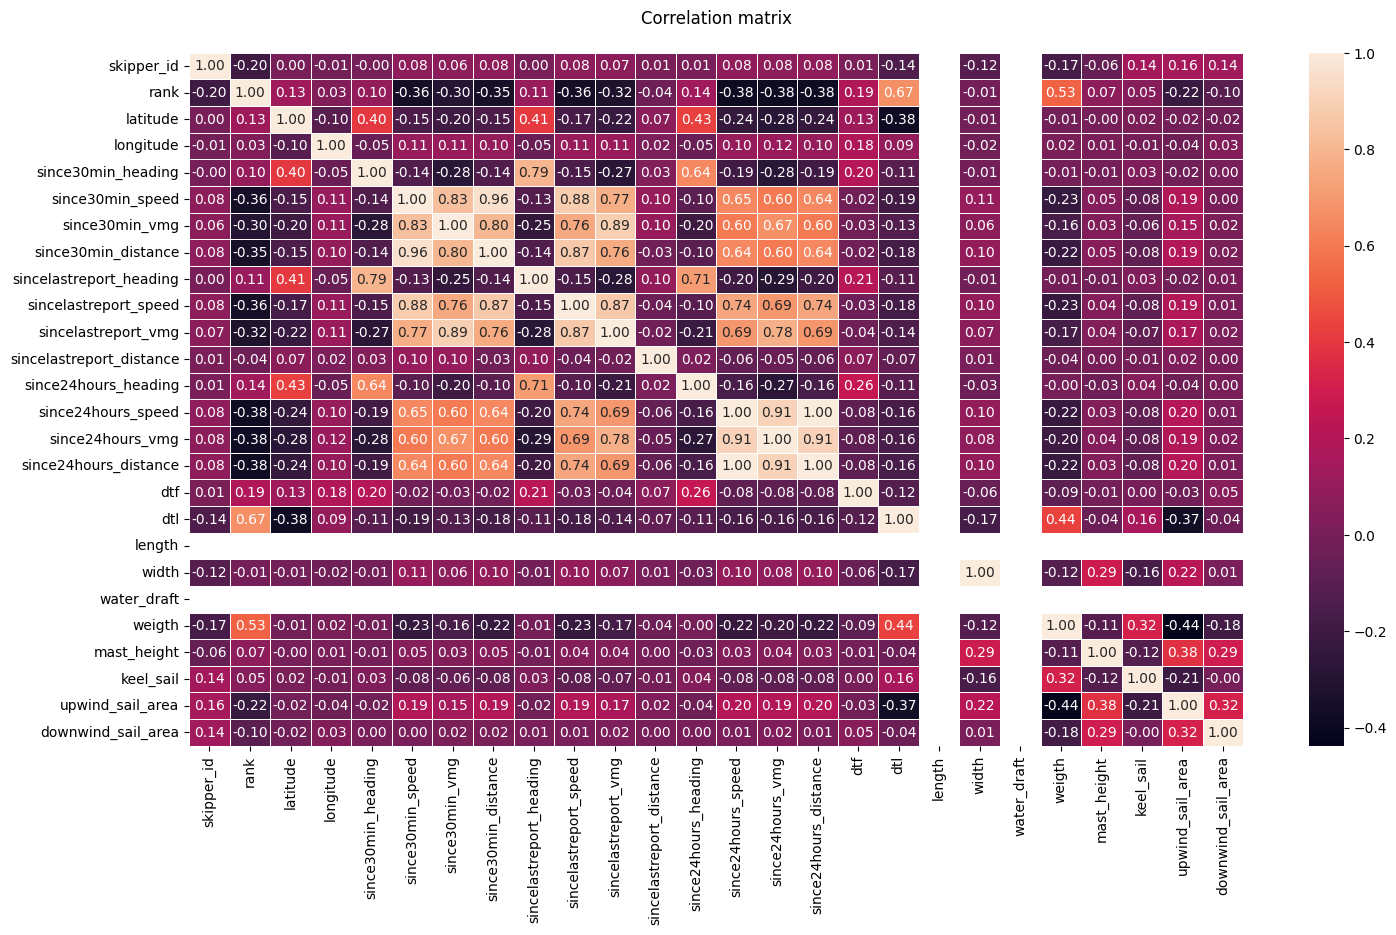

In [33]:
df_corr = df_skippers_with_boats.copy()
corr_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(17, 9))  
sns.heatmap(corr_matrix, annot=True, linewidths=.5, fmt=".2f", ax=ax)
plt.title("Correlation matrix\n")
plt.show()

In [34]:
def display_LR(X, y, flag_tts=False, verbose=False):
    """ Display skippers ranking timeline """
    # Split data
    if flag_tts:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    else:
        X_train, X_test, y_train, y_test = X, np.linspace(X.min(), X.max(), 100).reshape(-1, 1), y, y
    if verbose:
        print(f"\nX_train.shape: {X_train.shape}\ny_train.shape: {y_train.shape}")
        print(f"X_test.shape: {X_test.shape}\ny_test.shape: {y_test.shape}")
    
    # Apply Linear Regression
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(f"Model parameters:\n\t- coefficients: {reg.coef_[0]}\n\t- intercept: {reg.intercept_}\n\t- R2: {reg.score(X_train, y_train)}")

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=X_train.T[0], 
            y=y_train.reshape(-1, 1).T[0],
            mode='markers',
            name="skipper_vmg",
            marker_color='blue',
            hovertemplate="<b>VMG mean</b>: %{x}<br><b>Skipper rank</b>: %{y}"
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=X_test.T[0], 
            y=y_pred.reshape(-1, 1).T[0],
            mode='lines',
            name="Linear Regression",
            marker_color='red',
            hovertemplate="<b>VMG mean</b>: %{x}<br><b>Predicted skipper rank</b>: %{y}"
        )
    )

    fig.update_traces(marker_line_width=1, marker_size=8)
    fig.update_layout(
        width=1200, height=800, 
        title=dict(text=f"<b>Evolution of skipper rank with VMG</b>", x=.5),
        xaxis=dict(title='VMG mean over the race (in kts)'),
        yaxis=dict(title='Skipper rank'),
    )
    fig.update_xaxes(showspikes=True, spikecolor="green", spikesnap="cursor", spikemode="across")
    fig.update_yaxes(showspikes=True, spikethickness=2)
    fig.show()

In [35]:
df_reg = df_skippers_with_boats[['skipper_id', 'sincelastreport_vmg', 'rank']].copy()
df_reg['rank'] = df_reg['rank'].apply(lambda x: N_skippers if x == -1 else x)

# Select all rows without NaN 
df_reg = df_reg[~(df_reg.isnull().any(axis=1))]

# Group data by skipper
df_reg = df_reg.groupby(by='skipper_id').mean()

# Apply Linear Regression
X = df_reg[['sincelastreport_vmg']].to_numpy()
y = df_reg['rank'].to_numpy()

df_reg

,sincelastreport_vmg,rank
skipper_id,,
0,8.581000,26.965000
1,11.333826,13.415896
2,9.207463,24.819403
3,12.723395,4.374741
4,11.402041,21.430427
5,10.812014,17.452297
6,12.840373,6.809524
7,10.463870,19.964041
8,9.818810,21.302251


##### La regression linéaire permet de prédire le classement d'un skipper en fonction de sa VMG. Le coefficient de détermination, noté R2, est de 0.70 donc la qualité de prédiction du modèle est relativement correct sachant que seule la VMG est prise en compte dans le modèle.


##### Plus la VMG d'un skipper est élévée, meilleur sera son classement.

In [36]:
display_LR(X, y)

Model parameters:
	- coefficients: -4.714302761713916
	- intercept: 67.03567787099405
	- R2: 0.7089524778809647


### C) Impact de la présence d'un foil sur le classement et la vitesse des voiliers.

In [37]:
def display_foil_influence(df_skipper_foils):
    """ Display foil influence over skipper rank ang vmg mean """
    fig = go.Figure()
    for foil_type in df_skipper_foils['foil_type'].unique().tolist():
        fig.add_trace(
            go.Scatter(
                x=df_skipper_foils[df_skipper_foils['foil_type']==foil_type]['vmg'], 
                y=df_skipper_foils[df_skipper_foils['foil_type']==foil_type]['rank'],
                mode='markers',
                name=f"{foil_type} foils",
                customdata=df_skipper_foils[df_skipper_foils['foil_type']==foil_type]['skipper_id'].tolist(),
                hovertemplate="<b>Skipper id</b>: %{customdata}<br><b>VMG</b>: %{x}<br><b>Skipper rank</b>: %{y}"+f"<br><b>Boat foil type</b>: {foil_type} foils",
                legendgrouptitle_text="Foil type:",
            )
        )
    fig.update_traces(marker_line_width=1, marker_size=8)
    fig.update_layout(
        width=1200, height=800, 
        title=dict(text=f"<b>Evolution of skipper rank with VMG</b>", x=.5),
        xaxis=dict(title='VMG mean (in kts)'),
        yaxis=dict(title='Skipper rank'),
    )
    fig.update_yaxes(tickvals=list(range(1, df_skipper_foils.shape[0]))+[34])
    fig.show()

In [38]:
df_skipper_foils = pd.DataFrame()
for skipper_id in df_timeline['skipper_id'].unique().tolist():
    df_tmp = df_timeline[df_timeline['skipper_id']==skipper_id].iloc[[0]]
    df_tmp['datetime'] = df_tmp.index
    df_skipper_foils = pd.concat([df_skipper_foils, df_tmp], ignore_index=True)

df_skipper_foils = df_skipper_foils.sort_values(by='rank').reset_index(drop=True)
df_skipper_foils['vmg'] = df_skipper_foils['skipper_id'].apply(lambda x: get_skipper_timeline(df_all_skippers, x)['sincelastreport_vmg'].dropna().mean())
df_skipper_foils['foil_type'] = df_skipper_foils['skipper_id'].apply(lambda x: df_boats_characteristics[df_boats_characteristics['skipper_id']==x]['drift_amount'].values[0])
df_skipper_foils = df_skipper_foils.drop(columns=['skipper_lastname', 'skipper_firstname', 'datetime', 'skipper_status'])

df_skipper_foils

,skipper_id,rank,vmg,foil_type
0,3,1,12.723395,>2
1,10,2,12.773597,>2
2,6,3,12.840373,>2
3,21,4,12.555328,2
4,18,5,12.779381,>2
5,26,6,12.678099,>2
6,27,7,12.667901,2
7,24,8,12.689300,>2
8,13,9,12.544196,2
9,30,10,12.365323,2


##### Cette partie consiste à analyser l'importance du type de foils d'un voilier. On constate ci-dessous que 3 types de foils sont utilisés: 2 foils, 2 foils asymétriques et +2 foils. D'après le graphe, il est difficile de trancher sur le type de foils permettant d'améliorer le classement en regardant uniquement le classement final.<br>Néanmoins, on peut dire que les voiliers possédant 2 foils asymétriques ne sont pas les plus performants et que les voiliers avec +2 foils sont meilleurs que ceux avec uniquement 2 foils.

In [39]:
display_foil_influence(df_skipper_foils)

### D) Visualisation de la distance parcourue par voilier.

In [40]:
def display_skipper_distance_travelled(df_skippers_distance):
    """ Display distance travelled by skippers """
    skipper_ids = df_skippers_distance['skipper_id'].unique().tolist()
    colors = generate_color_categories(skipper_ids)
    
    fig = go.Figure()
    for skipper_id in skipper_ids:
        df_skipper = df_skippers_distance[df_skippers_distance['skipper_id']==skipper_id]
        skipper_rank = df_skipper['skipper_rank'].values[0]
        fig.add_trace(
            go.Bar(
                x=[f"skipper {skipper_id}"], 
                y=df_skipper['sincelastreport_distance'].tolist(),
                name=f"{skipper_id} (rank #{skipper_rank})",
                text=f"#{skipper_rank}",
                marker_color=colors[skipper_id],
                hovertemplate="<b>Skipper id</b>: %{x}<br><b>Distance travelled</b>: %{y}"+f"<br><b>Skipper rank</b>: {skipper_rank}",
                legendgrouptitle_text="Skipper that have abandonned the race" if skipper_rank == 34 else "Skipper that have finished the race",
                legendgroup = 'abandonned' if skipper_rank == 34 else 'finished',
                marker_pattern_shape="x" if skipper_rank == 34 else None
            )
        )
    # fig.update_traces(marker_line_width=1, marker_size=8)
    fig.update_layout(
        width=1200, height=800, 
        title=dict(text=f"<b>Distance travelled by skippers</b>", x=.5),
        xaxis=dict(title='Skipper id'),
        yaxis=dict(title='Distance (in nm)'),
        uniformtext_minsize=8, uniformtext_mode='show',
    )
    fig.update_traces(textposition='outside')
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

In [41]:
df_skippers_distance = df_all_skippers[['skipper_id', 'sincelastreport_distance']]
df_skippers_distance = df_skippers_distance.dropna()
df_skippers_distance = df_skippers_distance.groupby(by='skipper_id').sum()
df_skippers_distance.insert(0, 'skipper_id', df_skippers_distance.index)
df_skippers_distance['skipper_rank'] = df_skippers_distance['skipper_id'].apply(lambda x: df_skipper_foils[df_skipper_foils['skipper_id']==x]['rank'].values[0])
df_skippers_distance = df_skippers_distance.sort_values(by='sincelastreport_distance', ascending=False)
df_skippers_distance = df_skippers_distance.reset_index(drop=True)
df_skippers_distance

,skipper_id,sincelastreport_distance,skipper_rank
0,4,31813.2,13
1,19,31342.3,25
2,28,31334.9,16
3,8,31089.6,23
4,22,30984.0,18
5,25,30913.6,17
6,10,30889.8,2
7,26,30868.2,6
8,5,30702.9,15
9,6,30601.0,3


##### L'histogramme ci-dessous représente la distance parcourue par chaque skipper. Il est intéressant de noter que les skippers les mieux classés à l'arrivée ne sont pas ceux qui ont parcouru le plus de distance:
- #1 : le skipper_id 3 est 14ème à avoir parcouru le plus de distance
- #1 : le skipper_id 10 est 7ème à avoir parcouru le plus de distance
- #3 : le skipper_id 6 est 9ème à avoir parcouru le plus de distance

In [42]:
display_skipper_distance_travelled(df_skippers_distance)

### E) Cartes avec les routes d'un ou plusieurs voiliers.

In [43]:
from operator import itemgetter

def add_skipper_route(map, df, skipper_id, no, flag_popup_msg=False):
    """ Add skipper route """
    colors = ['#7590ba', '#ba7575', '#b0ba75']
    pulse_colors = ['#3f6fba', '#db4848', '#cfe35b']
    
    # Create skipper dataframe
    df_skipper = get_skipper_timeline(df, skipper_id)
    df_skipper = df_skipper.set_index('ranking_datetime')
    df_skipper = df_skipper.sort_index(ascending=True)
    df_skipper.index = pd.to_datetime(df_skipper.index)
    
    # Get locations
    locations = list(zip(df_skipper['latitude'].tolist(), df_skipper['longitude'].tolist()))
    idx_threshold = np.argmax(df_skipper['longitude'].tolist())+1
    locations1 = locations[:idx_threshold]
    locations2 = locations[idx_threshold:]

    
    # Add AntPath
    ant_path = AntPath(
        locations=locations1,
        dash_array=[1, 10],
        delay=1000,
        color=colors[no],
        pulse_color=pulse_colors[no],
        name=f'skipper {skipper_id}'
    )
    map.add(ant_path)
    ant_path = AntPath(
        locations=locations2,
        dash_array=[1, 10],
        delay=1000,
        color=colors[no],
        pulse_color=pulse_colors[no],
        name=f'skipper {skipper_id}'
    )
    map.add(ant_path)
    
    # Add message
    if flag_popup_msg:
        msg = HTML()
        msg.value = f'skipper {skipper_id}'
        popup = Popup(
            location=locations[(no+1)*50],
            child=msg,
            close_button=False,
            auto_close=False,
            close_on_escape_key=False
        )
        map.add_layer(popup)
    
    return map


def initialize_map(starting_location, icon_anchor):
    """ Initialize world map
    Args:
        starting_location (Tuple of float): starting location
        icon_anchor (Icon object): anchor icon
    Returns:
        world_map: world map object
    """
    # Create Map
    world_map = Map(center = (-7.362467, -15.117188), zoom=2, close_popup_on_click=False)
    world_map.layout.height = '600px'
    
    # Tracker: marker to simulate movement of the vehicle along the path:
    tracker = Marker(location=starting_location, name='Start race', title='Start race', icon=icon_anchor, draggable=False)
    world_map.add_layer(tracker)
    
    # Add display parameters
    control = LayersControl(position='topright')
    measure = MeasureControl(
        position='bottomleft',
        active_color = 'orange',
        primary_length_unit = 'kilometers'
    )
    world_map.add_control(control)
    world_map.add_control(FullScreenControl())
    world_map.add_control(measure)
    return world_map


def get_starting_location(df, skipper_id=0):
    """ Get starting location """
    # Create skipper dataframe
    df_skipper = get_skipper_timeline(df, skipper_id)
    df_skipper = df_skipper.set_index('ranking_datetime')
    df_skipper = df_skipper.sort_index(ascending=True)
    df_skipper.index = pd.to_datetime(df_skipper.index)

    # Get starting location
    starting_location = list(zip(df['latitude'].tolist(), df['longitude'].tolist()))[0]
    return starting_location



def plot_skipper_roadmap(df, skippers_id, frame_time=.5, flag_popup_msg=False):
    """ Plot skipper roadmap
    Args:
        df (DataFrame): skipper in race data
        skipper_id (Integer): skipper id
        frame_time (Float, optional): waiting time between each frames. Defaults 0.1 seconds
    Returns:
        None
    """
    # Get starting location
    starting_location = get_starting_location(df, skipper_id=0)
    
    # Initialize icons
    icon_anchor = AwesomeIcon(name='anchor', marker_color='green', icon_color='black', spin=False)
    icon_ship = AwesomeIcon(name='ship', marker_color='purple', icon_color='black', spin=False)

    # Inialize world_map
    world_map = initialize_map(starting_location, icon_anchor=icon_anchor)

    # Add skipper route
    for no, skipper_id in enumerate(skippers_id):
        world_map = add_skipper_route(world_map, df, skipper_id, no=no, flag_popup_msg=flag_popup_msg)
    
    # Display roadmap
    display(world_map)

    # Display marker along the skipper route
    # locations = list(zip(df_skipper['latitude'].tolist(), df_skipper['longitude'].tolist()))
    # trackers, old_tracker = [], None
    # for step_no, location in enumerate(locations[::2]):
    #     time.sleep(frame_time)
        
    #     tracker = Marker(location=location, name='Current step', title='Current step', icon=icon_ship, draggable=False)
        
    #     world_map.add(tracker)
    #     trackers.append(tracker)
        
    #     if old_tracker:
    #         world_map.remove(old_tracker)
    #     old_tracker = tracker
        
    #     # if step_no > 100:
    #     #     break

##### Affichons la trajectoire de certains skippers

In [44]:
skippers_id = [6, 10, 3]
plot_skipper_roadmap(df_skippers_in_race, skippers_id)

Map(center=[-7.362467, -15.117188], close_popup_on_click=False, controls=(ZoomControl(options=['position', 'zo…

### F) Analyses de séries temporelles.

In [45]:
def display_skippers_distance_timeline(df_skipper_distance_timeline, skipper_id):
    """ Display skippers distance timeline """
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=df_skipper_distance_timeline.index, 
            y=df_skipper_distance_timeline['sincelastreport_distance'],
            mode='lines',
            name="distance travelled",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df_skipper_distance_timeline.index, 
            y=df_skipper_distance_timeline['sincelastreport_distance'].mean()*np.ones(df_skipper_distance_timeline.shape[0]),
            mode='lines',
            name="distance mean"
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df_skipper_distance_timeline.index, 
            y=df_skipper_distance_timeline['sincelastreport_distance'].min()*np.ones(df_skipper_distance_timeline.shape[0]),
            mode='lines',
            name="distance min"
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df_skipper_distance_timeline.index, 
            y=df_skipper_distance_timeline['sincelastreport_distance'].max()*np.ones(df_skipper_distance_timeline.shape[0]),
            mode='lines',
            name="distance max"
        )
    )

    fig.update_traces(marker_line_width=1, marker_size=8)
    fig.update_layout(
        width=1200, height=800, 
        title=dict(text=f"<b>Distance travelled over time by skipper {skipper_id}</b>", x=.5),
        legend_title_text='Distance:',
    
        xaxis=dict(title='Timeline', side='left', rangeslider=dict(visible=True, thickness=0.15)),
        yaxis=dict(title='Distance travelled since last report (in nm)'),
        
        hovermode = "x unified"
    )
    fig.show()

In [46]:
skipper_id = 3
df_skipper = get_skipper_timeline(df_skippers_in_race, skipper_id=skipper_id)
df_skipper = df_skipper.set_index('ranking_datetime')
df_skipper = df_skipper.sort_index(ascending=True)
df_skipper.index = pd.to_datetime(df_skipper.index)
df_skipper = df_skipper[['sincelastreport_distance']][1:]


display_skippers_distance_timeline(df_skipper, skipper_id)
df_skipper

,sincelastreport_distance
ranking_datetime,
2020-11-08 17:00:00,25.3
2020-11-08 19:00:00,32.4
2020-11-08 23:00:00,58.6
2020-11-09 06:00:00,86.0
2020-11-09 10:00:00,42.5
...,...
2021-01-27 05:00:00,136.9
2021-01-27 09:00:00,77.1
2021-01-27 12:00:00,49.8


### G) Application d'algorithmes statistiques ou de machine learning.

### H) etc.

In [47]:
df_skippers_groupby = df_skippers_in_race[['skipper_id', 'sincelastreport_speed', 'sincelastreport_vmg', 'sincelastreport_distance']].groupby(by='skipper_id').mean()
df_skippers_groupby.columns = [str(col.replace('sincelastreport_', '')) + '_mean' for col in df_skippers_groupby.columns]

df_skippers_groupby.insert(0, 'skipper_id', df_skippers_groupby.index)
for col in df_skippers_groupby.columns[1:]:
    df_skippers_groupby[f'{col}_norm'] = (df_skippers_groupby[col]-df_skippers_groupby[col].min())/(df_skippers_groupby[col].max()-df_skippers_groupby[col].min())*100

df_skippers_groupby['nationality'] = df_skippers_groupby['skipper_id'].apply(lambda x: df_boats_characteristics[df_boats_characteristics['skipper_id']==x]['nationality'].values[0])
df_skippers_groupby['nationality'] = df_skippers_groupby['nationality'].fillna('')
df_skippers_groupby['nationality_encoded'] = df_skippers_groupby['nationality'].astype('category').cat.codes*10
df_skippers_groupby

,skipper_id,speed_mean,vmg_mean,distance_mean,speed_mean_norm,vmg_mean_norm,distance_mean_norm,nationality,nationality_encoded
skipper_id,,,,,,,,,
0,0,10.658500,8.581000,55.966000,22.308049,12.969052,18.841566,FRA,30
1,1,12.512384,11.333826,55.020702,58.117592,69.217025,17.292316,FRA,30
2,2,10.396119,9.207463,45.263731,17.239918,25.769444,1.301595,FRA,30
3,3,14.425052,12.723395,62.900207,95.062582,97.609827,30.206053,,0
4,4,13.520223,11.402041,59.022635,77.584946,70.610840,23.851091,,0
5,5,12.390283,10.812014,54.245406,55.759080,58.554937,16.021681,FRA,30
6,6,14.610145,12.840373,63.356108,98.637832,100.000000,30.953229,,0
7,7,11.912842,10.463870,52.282021,46.536867,51.441372,12.803884,ESP,10
8,8,11.460129,9.818810,49.983280,37.792268,38.260993,9.036473,FRA,30


In [48]:
natvalue2nat = dict(zip(df_skippers_groupby['nationality'].unique(), df_skippers_groupby['nationality_encoded'].unique()))
print(f"natvalue2nat: {natvalue2nat}")

nat2natvalue = {v:k for k,v in natvalue2nat.items()}
print(f"nat2natvalue: {nat2natvalue}")

natvalue2nat: {'FRA': 30, '': 0, 'ESP': 10, 'GBR': 40, 'FIN': 20, 'ITA': 50, 'SUI': 70, 'JPN': 60}
nat2natvalue: {30: 'FRA', 0: '', 10: 'ESP', 40: 'GBR', 20: 'FIN', 50: 'ITA', 70: 'SUI', 60: 'JPN'}


In [49]:
# Radar chart with skipper characteristics (vmg_mean, total distance, rank, nb foils)
categories = ['rank_mean', 'distance_travelled_mean', 'distance_travelled_total', 'foils_type', 'nationality']
categories = ['speed_mean_norm', 'vmg_mean_norm', 'distance_mean_norm', 'nationality_encoded']

fig = go.Figure()

skipper_ids = df_skippers_groupby.index.tolist()
for skipper_id in skipper_ids:
    r = df_skippers_groupby[df_skippers_groupby['skipper_id']==skipper_id][categories].to_numpy()[0]
    
    text = f"<b>Skipper id</b>: {skipper_id}<br><br>"
    for i in range(len(categories)):
        if categories[i] == 'nationality_encoded':
            text += f"<b>{categories[i].replace('_encoded', '')}<b>: {nat2natvalue[r[i]]}<br>"
        elif 'norm' in categories[i]:
            cat = categories[i].replace('_norm', '')
            text += f"<b>{categories[i].replace('_norm', '')}<b>: {df_skippers_groupby[df_skippers_groupby['skipper_id']==skipper_id][cat].values[0]}<br>"
        else: 
            text += f"<b>{categories[i]}<b>: {round(r[i], 2)}<br>"
    
    fig.add_trace(
        go.Scatterpolar(
            r=r,
            theta=categories,
            fill='toself',
            name=f'skipper {skipper_id}',
            hovertemplate=text
        )
    )

fig.update_layout(
    width=1200, height=800, 
    title=dict(text=f"<b>Skippers characteristics</b>", x=.5),
    legend_title_text='Skipper:',
)
fig.show()

In [50]:
# Plot skippers by countries
df_skippers_nationality = df_skippers_groupby.copy()
df_skippers_nationality = df_skippers_nationality[['skipper_id', 'nationality']].groupby('nationality').count()
df_skippers_nationality['nationality'] = df_skippers_nationality.index
df_skippers_nationality = df_skippers_nationality.reset_index(drop=True)
df_skippers_nationality = df_skippers_nationality.rename(columns={'skipper_id':'skipper_count'})
df_skippers_nationality['nationality'] = df_skippers_nationality['nationality'].replace('', 'UNKNOWN')

nationalities = df_skippers_nationality['nationality'].tolist()
counts = df_skippers_nationality['skipper_count'].tolist()

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=nationalities, 
        values=counts, 
        hole=.3,
        hovertemplate="<b>Nationality</b>: %{label}<br><b>Skippers count</b>: %{value}<br><b>Repartition</b>: %{value}"+f"/{df_skippers_nationality['skipper_count'].sum()} skippers"
    )
)

fig.update_layout(
    width=1200, height=800, 
    title=dict(text=f"<b>Skippers nationality</b>", x=.5),
    legend_title_text='Nationality:',
)
fig.show()

df_skippers_nationality

,skipper_count,nationality
0,9,UNKNOWN
1,1,ESP
2,1,FIN
3,17,FRA
4,2,GBR
5,1,ITA
6,1,JPN
7,1,SUI


In [51]:
# Delete directory (useful while testing data retrieval: scraping + preprocessing + loading data)

# remove_dir(ranking_dir_dst)
# remove_dir(uuid_dir_dst)

# remove_dir(skippers_race_status_raw_dir_dst)
# remove_dir(skippers_race_status_preprocessed_dir_dst)

# remove_dir(boat_raw_dir_dst)
# remove_dir(boat_preprocessed_dir_dst)